<Axes: >

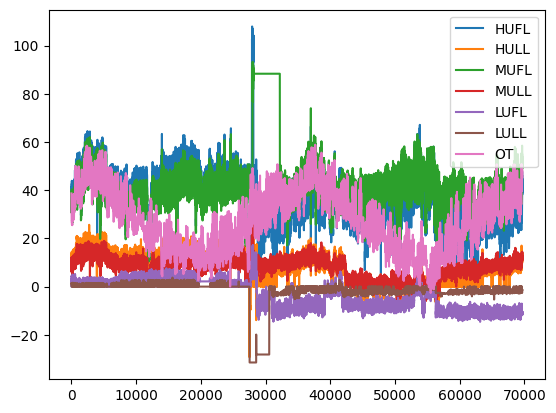

In [36]:
import pandas as pd 

df = pd.read_csv("ETTm2.csv")
df.plot()

In [42]:
df['date'] = pd.to_datetime(df['date'])
training_df = df[df['date'] < df['date'].min() + pd.DateOffset(months=12)]
val_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=12)][df['date'] < df['date'].min() + pd.DateOffset(months=16)]
test_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=16)][df['date'] < df['date'].min() + pd.DateOffset(months=20)]

/tmp/ipykernel_7468/2599488179.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=12)][df['date'] < df['date'].min() + pd.DateOffset(months=16)]
/tmp/ipykernel_7468/2599488179.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=16)][df['date'] < df['date'].min() + pd.DateOffset(months=20)]


In [47]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self,df, target_column,drop_cols,future_steps, p_lag=0):
        self.df = df.drop(drop_cols, axis=1)
        self.p_lag = p_lag
        self.len_df_minus_lag = len(self.df) - p_lag - future_steps
        self.target_column = target_column
        self.future_steps = future_steps
        
    def __len__(self):
        return self.len_df_minus_lag

    def __getitem__(self, idx):
        input_p_lag = torch.tensor(self.df.iloc[(idx):(idx + self.p_lag),:].astype(float).to_numpy().transpose().reshape(1,-1), requires_grad=True)
        target = torch.tensor(self.df[self.target_column].iloc[(idx + self.p_lag): (idx + self.p_lag + self.future_steps),:].astype(float).to_numpy()).reshape(1,-1)
        return input_p_lag, target

In [48]:
import math
import torch.nn as nn
from torch.nn.functional import normalize

import torch
from torch import nn

class DecompositionLayer(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) 

    def forward(self, x):
        num_of_pads = (self.kernel_size - 1) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

class ARNet(nn.Module):
    def __init__(self, p_lag, n_features, future_steps, decomp_kernel_size = 7):
        super(ARNet, self).__init__()
        self.input_trend_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/2))
        self.output_trend_layer = nn.Linear(math.ceil(p_lag * n_features/2), future_steps)
        self.input_seasonal_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/2))
        self.output_seasonal_layer = nn.Linear(math.ceil(p_lag * n_features/2), future_steps)
        self.decomp_layer = DecompositionLayer(decomp_kernel_size)
        self.criterion = nn.MSELoss()

    def forward(self, input):
        input = input.float()
        input_season, input_trend = self.decomp_layer(input)
        x_season = self.input_seasonal_layer(input_season)
        y_hat_season = self.output_seasonal_layer(x_season)
        x_trend = self.input_trend_layer(input_trend)
        y_hat_trend = self.output_trend_layer(x_trend)

        return y_hat_season + y_hat_trend

In [49]:
from torch.utils.data import DataLoader

p_lag = 100
future_steps = 10

net = ARNet(p_lag=p_lag, n_features=7, future_steps=future_steps, decomp_kernel_size=7)

train_data = DataLoader(TimeSeriesDataset(training_df, future_steps= future_steps, target_column = ['OT'],drop_cols='date',p_lag=p_lag))
train_loss_list = []
test_data = DataLoader(TimeSeriesDataset(val_df,future_steps= future_steps, target_column = ['OT'],drop_cols='date',p_lag=p_lag))
test_loss_list = []

torch.set_grad_enabled(True)
optimizer = torch.optim.Adam(net.parameters(), lr=1.e-5)
running_train_loss = 0.
running_test_loss = 0.
train_counter = 1
test_counter = 1
for epoch in range(1): 
    print("---------------------------")
    for i, data in enumerate(train_data):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = net.criterion(outputs.squeeze(0), labels.squeeze(0).float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
        optimizer.step()
        running_train_loss += loss.item()
        train_counter += 1
        if train_counter % 10000 == 0: 
            print(f"Current (running) training loss at iteration {train_counter} : {running_train_loss/train_counter}")

    train_loss_list.append(running_train_loss/train_counter)
        
    for i, data in enumerate(test_data):
        inputs, test_labels = data
        output = net(inputs)
        test_loss = net.criterion(output.squeeze(0), test_labels.squeeze(0).float())
        running_test_loss += test_loss.item()
        test_counter += 1
    test_loss_list.append(running_test_loss/test_counter)

    if epoch % 1 == 0: 
        print(f"Epoch {epoch}: ")
        print(f"Running (training) loss is {running_train_loss/train_counter}.")
        print(f"Test loss is {running_test_loss/test_counter}.")
        print("---------------------------")


---------------------------


In [32]:
for i, data in enumerate(test_data):
    inputs, labels = data
    output = net(inputs)
    print(f"predicted output is {output.squeeze(0,1).tolist()} and true value is {labels.squeeze(0,1).tolist()}")

predicted output is [4.32839298248291, 3.7384769916534424, 3.441099166870117, 3.025506019592285, 2.743251323699951, 2.3982739448547363, 2.303544044494629] and true value is [6.581999778747559, 6.581999778747559, 6.581999778747559, 6.362500190734862, 6.362500190734862, 6.362500190734862, 6.362500190734862]
predicted output is [4.052770614624023, 3.4713327884674072, 3.0936334133148193, 3.328275680541992, 2.1478137969970703, 2.723335027694702, 1.8174184560775757] and true value is [6.581999778747559, 6.581999778747559, 6.362500190734862, 6.362500190734862, 6.362500190734862, 6.362500190734862, 6.142499923706055]
predicted output is [4.321321964263916, 3.829253673553467, 2.824188470840454, 3.0374014377593994, 2.3709158897399902, 2.121002197265625, 1.7650271654129028] and true value is [6.581999778747559, 6.362500190734862, 6.362500190734862, 6.362500190734862, 6.362500190734862, 6.142499923706055, 6.142499923706055]
predicted output is [3.916712999343872, 3.9682679176330566, 3.008792400360

predicted output is [10.704741477966309, 10.453570365905762, 7.426774978637695, 7.914002418518066, 6.849757194519043, 5.998371124267578, 4.869034290313721] and true value is [12.73449993133545, 12.294500350952148, 11.85550022125244, 11.196499824523926, 10.756999969482422, 10.317500114440918, 9.657999992370604]
predicted output is [10.087935447692871, 9.961085319519043, 6.844202041625977, 7.214444160461426, 6.395692348480225, 5.481257438659668, 4.2565836906433105] and true value is [12.294500350952148, 11.85550022125244, 11.196499824523926, 10.756999969482422, 10.317500114440918, 9.657999992370604, 9.43850040435791]
predicted output is [9.5449857711792, 9.304939270019531, 6.34906005859375, 6.613341808319092, 5.774353504180908, 5.022994041442871, 3.8538613319396973] and true value is [11.85550022125244, 11.196499824523926, 10.756999969482422, 10.317500114440918, 9.657999992370604, 9.43850040435791, 8.99899959564209]
predicted output is [9.125826835632324, 8.862548828125, 5.83167791366577

KeyboardInterrupt: 

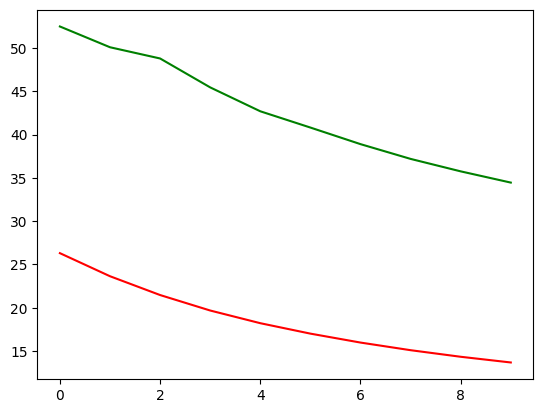

In [6]:
import matplotlib.pyplot as plt
plt.plot(test_loss_list, 'g', train_loss_list, 'r')
plt.show()